In [1]:
import pymc as pm
import pandas as pd
import numpy as np
import arviz as az
from matplotlib import pyplot as plt
from pymc import sampling_jax
import pytensor as pt
import arviz as az
import altair as alt
pm.__version__

/home/aurimas/micromamba/envs/pymc5/lib/python3.11/site-packages/pymc/sampling/jax.py:39: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


'5.0.2'

Now let the causal effect of children vary by district. Incorporate this new district feature into the same multivariate prior that contains the urban/rural features. How much do districts vary in how surviving children are associated with contraceptive
use?

In [2]:
bangladesh = pd.read_csv('../../../datasets/bangladesh.csv')

#factorize districts
d_idx, districts = pd.factorize(bangladesh['district'], sort=True)
#factorize out children counts; we will assume a monotonic effect for them
children_idx, children = pd.factorize(bangladesh['living.children'], sort=True)
std_age = bangladesh[['age.centered']].apply(lambda x: (x-x.mean())/ x.std(), axis=0)

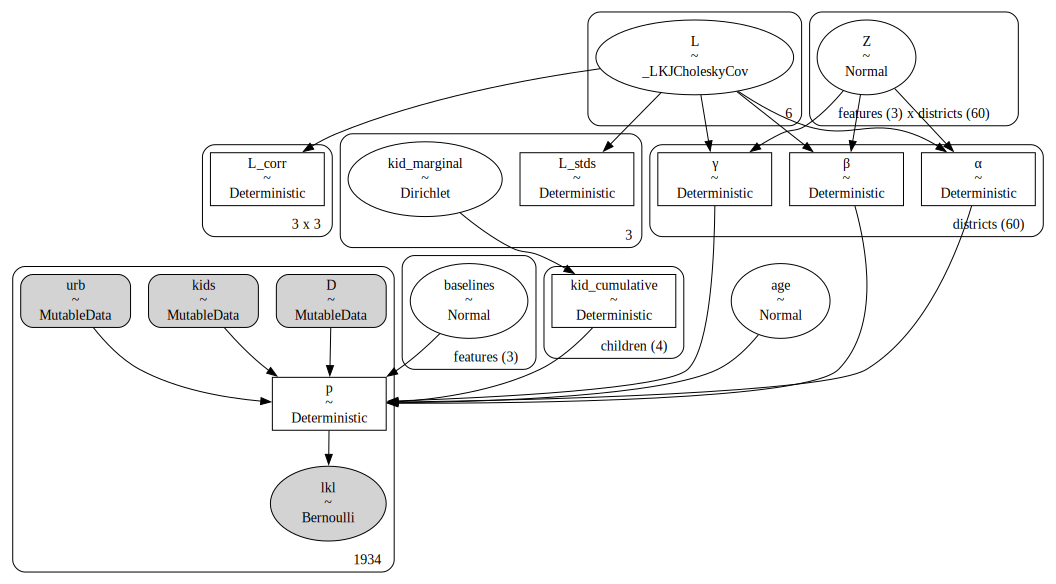

In [3]:
coords = {
    "districts": districts,
    "children": children,
    "features": ["district", "urban", "children"],   
    "urbanity": ["rural", "urban"] 
}

with pm.Model(coords = coords) as ex3_model_1:

    #data
    urbanity = pm.MutableData("urb", bangladesh['urban'].values, coords="urbanity")   
    kids = pm.MutableData('kids', children_idx, coords="children")
    D = pm.MutableData('D', d_idx, coords='districts')
    
    #district features    
    σ = pm.Exponential.dist(1.0, shape=len(coords['features']))
    baselines = pm.Normal("baselines", 0, 1, dims="features")    
    chol, corr, stds = pm.LKJCholeskyCov(
        'L', 
        n=len(coords['features']), 
        eta=4, 
        sd_dist=σ, 
        compute_corr=True        
    )

    Z = pm.Normal('Z', mu=0, sigma=1, dims=["features", "districts"])
    vals = pm.math.dot(chol, Z)
        
    α = pm.Deterministic("α", vals[0, :], dims="districts")
    β = pm.Deterministic("β", vals[1, :], dims="districts") 
    γ = pm.Deterministic("γ", vals[2, :], dims="districts")

    #monotonic effect on children        
    cutpoints = pm.Dirichlet("kid_marginal", a = np.ones((len(children) - 1,)))
    kid_impact = pm.Deterministic(
        "kid_cumulative", 
        pm.math.concatenate([pm.math.constant(0, ndim=1), cutpoints.cumsum(axis=0)], axis=0),
        dims=['children']
    )

    #age
    δ = pm.Normal("age", 0, 1)

    logit = baselines[0] + baselines[1]*urbanity + baselines[2]*kid_impact[kids] #baseline effects
    logit += α[D] + β[D]*urbanity + γ[D]*kid_impact[kids] #effects of districts    
    logit += std_age.values.reshape(-1,)*δ #age effect

    p = pm.Deterministic("p", pm.invlogit(logit))

    pm.Bernoulli("lkl", p = p, observed = bangladesh['use.contraception'].values)

pm.model_to_graphviz(ex3_model_1)

In [4]:
with ex3_model_1:
    ex3_trace_1 = sampling_jax.sample_blackjax_nuts()
    #ex3_trace_1 = pm.sample()

Compiling...


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Compilation time =  0:00:08.215978
Sampling...
Sampling time =  0:00:18.094313
Transforming variables...
Transformation time =  0:00:12.672610


In [5]:
az.summary(
    ex3_trace_1, 
    var_names=['baselines', 'kid_cumulative', 'L_corr', 'age', 'L_stds'], 
    round_to=2,
    coords={"L_corr_dim_0": [0,1], "L_corr_dim_1": [1,2], "children": [2,3,4]}
    ).head(n=20)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
baselines[district],-1.65,0.16,-1.95,-1.35,0.00,0.00,2751.60,2954.94,1.00
baselines[urban],0.74,0.17,0.43,1.07,0.00,0.00,2987.49,2083.02,1.00
baselines[children],1.34,0.18,1.00,1.66,0.00,0.00,3656.51,2921.21,1.00
kid_cumulative[2],0.79,0.09,0.64,0.95,0.00,0.00,4094.79,2889.19,1.00
kid_cumulative[3],0.92,0.06,0.82,1.00,0.00,0.00,3805.55,2255.94,1.00
kid_cumulative[4],1.00,0.00,1.00,1.00,0.00,0.00,3844.67,3801.22,1.00
"L_corr[0, 1]",-0.53,0.19,-0.86,-0.18,0.00,0.00,1903.86,2474.68,1.00
"L_corr[0, 2]",-0.24,0.30,-0.76,0.31,0.01,0.01,1330.60,2243.44,1.00
"L_corr[1, 1]",1.00,0.00,1.00,1.00,0.00,0.00,3821.59,3193.22,1.00
"L_corr[1, 2]",0.12,0.29,-0.42,0.66,0.01,0.00,2409.98,2827.89,1.00


How much do districts vary?

In [6]:
alt.Chart(
    pd.DataFrame({'district children effects' : ex3_trace_1['posterior']['L_stds'][:,:,2].to_numpy().ravel() })
).transform_density(
    'district children effects',
    as_=['effect', 'density'],
).mark_area().encode(
    x="effect:Q",
    y='density:Q',
).properties(title="Standard deviation of district children effects")

alt.Chart(...)

## Alternative parameterization of monotonic effect (softmax)

In [7]:
from scipy.special import logsumexp

a = np.array([0, 1,1,2,3]) 
np.exp(a) / np.exp(logsumexp(a))

array([0.02948882, 0.08015892, 0.08015892, 0.21789455, 0.59229879])

In [8]:
coords = {
    "districts": districts,
    "children": children,
    "features": ["district", "urban", "children"],   
    "urbanity": ["rural", "urban"] 
}

with pm.Model(coords = coords) as ex3_model_2:

    #data
    urbanity = pm.MutableData("urb", bangladesh['urban'].values, coords="urbanity")   
    kids = pm.MutableData('kids', children_idx, coords="children")
    D = pm.MutableData('D', d_idx, coords='districts')
    
    #district features    
    σ = pm.Exponential.dist(1.0, shape=len(coords['features']))
    baselines = pm.Normal("baselines", 0, 1, dims="features")    
    chol, corr, stds = pm.LKJCholeskyCov(
        'L', 
        n=len(coords['features']), 
        eta=4, 
        sd_dist=σ, 
        compute_corr=True        
    )

    Z = pm.Normal('Z', mu=0, sigma=1, dims=["features", "districts"])
    vals = pm.math.dot(chol, Z)
        
    α = pm.Deterministic("α", vals[0, :], dims="districts")
    β = pm.Deterministic("β", vals[1, :], dims="districts") 
    γ = pm.Deterministic("γ", vals[2, :], dims="districts")

    #monotonic effect on children using softmax
    # Should also be possible using a pymc Simplex transform, but I could not get it to work
    # np.exp(a) / np.exp(logsumexp(a))
    #        
    raw_cutpoints = pm.Normal(
        "kid_marginal", 
        shape = (len(children) - 1, ),         
    )
    cutpoints = raw_cutpoints.exp() / pm.math.logsumexp(raw_cutpoints).exp()    
    kid_impact = pm.Deterministic(
        "kid_cumulative", 
        pm.math.concatenate([pm.math.constant(0, ndim=1), cutpoints.cumsum(axis=0)], axis=0),
        dims=['children']
    )

    #age
    δ = pm.Normal("age", 0, 1)

    logit = baselines[0] + baselines[1]*urbanity #baseline effects
    logit += baselines[2]*kid_impact[kids] #baseline effects (kids)
    logit += α[D] + β[D]*urbanity #effects of districts    
    logit += γ[D]*kid_impact[kids] #effects of districts (kids)
    logit += std_age.values.reshape(-1,)*δ #age effect

    p = pm.Deterministic("p", pm.invlogit(logit))

    pm.Bernoulli("lkl", p = p, observed = bangladesh['use.contraception'].values)

In [9]:
with ex3_model_2:
    ex3_trace_2 = sampling_jax.sample_blackjax_nuts()
    #ex3_trace_2 = pm.sample()

Compiling...
Compilation time =  0:00:03.893630
Sampling...
Sampling time =  0:00:07.782216
Transforming variables...
Transformation time =  0:00:11.923979


In [10]:
az.summary(
    ex3_trace_2, 
    var_names=['baselines', 'kid_cumulative', 'L_corr', 'age', 'L_stds'], 
    round_to=2,
    coords={"L_corr_dim_0": [0,1], "L_corr_dim_1": [1,2], "children": [2,3,4]}
    ).head(n=20)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
baselines[district],-1.65,0.16,-1.95,-1.34,0.00,0.00,3408.27,2496.70,1.00
baselines[urban],0.74,0.17,0.41,1.06,0.00,0.00,3090.45,2806.33,1.00
baselines[children],1.35,0.18,1.01,1.67,0.00,0.00,3980.33,2797.40,1.00
kid_cumulative[2],0.78,0.08,0.63,0.93,0.00,0.00,4567.67,3173.92,1.00
kid_cumulative[3],0.91,0.05,0.81,0.99,0.00,0.00,5287.73,3537.59,1.00
kid_cumulative[4],1.00,0.00,1.00,1.00,0.00,0.00,4060.99,3746.67,1.00
"L_corr[0, 1]",-0.55,0.19,-0.87,-0.20,0.00,0.00,2165.93,2642.67,1.00
"L_corr[0, 2]",-0.24,0.31,-0.78,0.33,0.01,0.01,1202.94,1922.00,1.00
"L_corr[1, 1]",1.00,0.00,1.00,1.00,0.00,0.00,4158.40,3846.22,1.00
"L_corr[1, 2]",0.12,0.29,-0.44,0.64,0.01,0.00,2153.91,2853.65,1.00


## Varying monotonic effect model

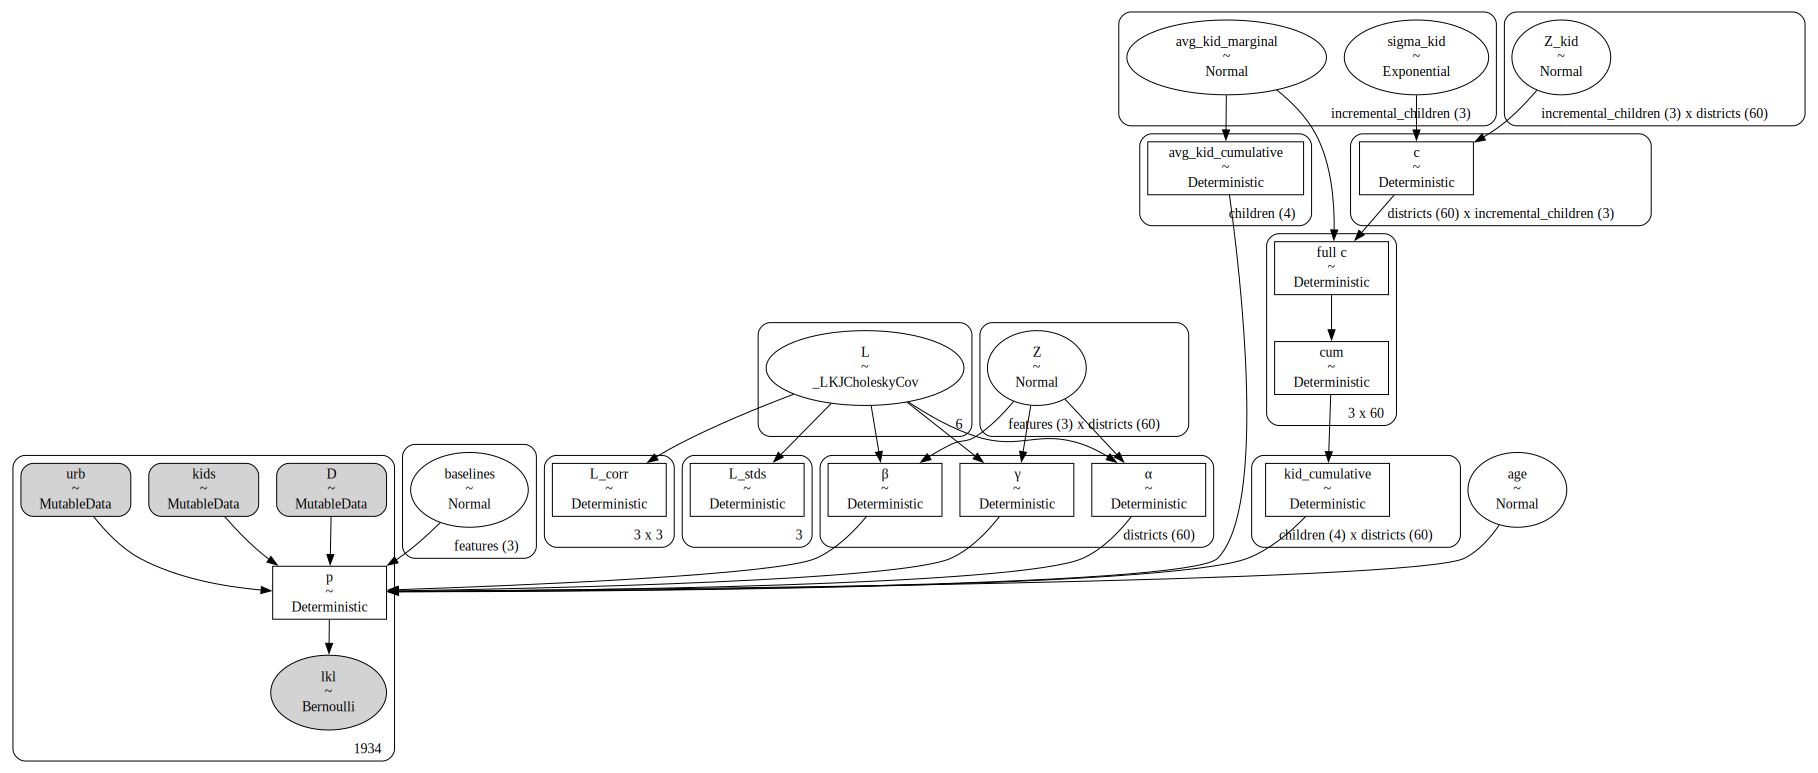

In [11]:
coords = {
    "districts": districts,
    "children": children,
    "incremental_children": children[1:],
    "features": ["district", "urban", "children"],   
    "urbanity": ["rural", "urban"] 
}

with pm.Model(coords = coords) as ex3_model_3:

    #data
    urbanity = pm.MutableData("urb", bangladesh['urban'].values, coords="urbanity")   
    kids = pm.MutableData('kids', children_idx, coords="children")
    D = pm.MutableData('D', d_idx, coords='districts')
    
    #district features    
    σ = pm.Exponential.dist(1.0, shape=len(coords['features']))
    baselines = pm.Normal("baselines", 0, 1, dims="features")    
    chol, corr, stds = pm.LKJCholeskyCov(
        'L', 
        n=len(coords['features']), 
        eta=4, 
        sd_dist=σ, 
        compute_corr=True        
    )

    Z = pm.Normal('Z', mu=0, sigma=1, dims=["features", "districts"])
    vals = pm.math.dot(chol, Z)
        
    α = pm.Deterministic("α", vals[0, :], dims="districts")
    β = pm.Deterministic("β", vals[1, :], dims="districts") 
    γ = pm.Deterministic("γ", vals[2, :], dims="districts")

    #monotonic effect on children using softmax
    # Should also be possible using a pymc Simplex transform, but I could not get it to work
    # np.exp(a) / np.exp(logsumexp(a))
    #        

    #these cutpoints are averages
    avg_raw_cutpoints = pm.Normal(
        "avg_kid_marginal",         
       dims='incremental_children'
    )     

    #save average monotonic effects for reference    
    avg_cutpoints = avg_raw_cutpoints.exp() / pm.math.logsumexp(avg_raw_cutpoints).exp()    
    avg_kid_impact = pm.Deterministic(
        "avg_kid_cumulative", 
        pm.math.concatenate([pm.math.constant(0, ndim=1), avg_cutpoints.cumsum(axis=0)], axis=0),
        dims=['children']
    )

    if True:

        #these are additions for each district; 
        Z_cuts = pm.Normal(
            "Z_kid", 
            mu=0, sigma=1,             
            dims=['incremental_children', 'districts']
        ) #3 x D

        #these are variations of the random effects per cut-off point
        sigmas = pm.Exponential(
            "sigma_kid", 
            1,             
            dims='incremental_children'
        ) # 3x1
        
        cutpoint_offsets = pm.Deterministic(
            "c", 
            Z_cuts.T * sigmas.T, # (D x 3) * (1 x 3) = D x 3
            dims=["districts", "incremental_children"]
        )

        #compute real monotonic effects with offsets
        raw_cutpoints = pm.Deterministic(
            "full c", 
            (
                avg_raw_cutpoints.flatten() + 
                cutpoint_offsets
            ).T)  #(1 x 3) + (D x 3) = D x 3
        cutpoints = raw_cutpoints.exp() / pm.math.logsumexp(raw_cutpoints, axis=0).exp() 
        cumulative_cutpoints = pm.Deterministic("cum", cutpoints.cumsum(axis=0))
        zeros = pm.math.constant(np.zeros((1, len(districts))))

        kid_impact = pm.Deterministic(
            "kid_cumulative", 
            pm.math.concatenate([zeros, cumulative_cutpoints], axis=0),
            dims=['children', 'districts']        
        ) 

    #age
    δ = pm.Normal("age", 0, 1)

    logit = baselines[0] + baselines[1]*urbanity #baseline effects
    logit += baselines[2]*avg_kid_impact[kids] #baseline effects (kids)
    logit += α[D] + β[D]*urbanity #effects of districts    
    logit += γ[D]*kid_impact[kids, D] #effects of districts (kids)
    logit += std_age.values.reshape(-1,)*δ #age effect

    p = pm.Deterministic("p", pm.invlogit(logit))

    pm.Bernoulli("lkl", p = p, observed = bangladesh['use.contraception'].values)

pm.model_to_graphviz(ex3_model_3)

In [12]:
with ex3_model_3:
    ex3_trace_3 = sampling_jax.sample_blackjax_nuts()
    #ex3_trace_3 = pm.sample()

Compiling...
Compilation time =  0:00:04.641658
Sampling...
Sampling time =  0:00:10.734885
Transforming variables...
Transformation time =  0:00:16.431216


In [13]:
az.summary(
    ex3_trace_3, 
    var_names=['baselines', 'avg_kid_cumulative', 'L_corr', 'age', 'L_stds', 'sigma_kid'], 
    round_to=2,
    coords={"L_corr_dim_0": [0,1], "L_corr_dim_1": [1,2], 'children': [2,3,4]}
    )

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
baselines[district],-1.65,0.15,-1.95,-1.37,0.00,0.00,2554.11,2091.00,1.00
baselines[urban],0.74,0.17,0.42,1.06,0.00,0.00,2606.63,2138.76,1.00
baselines[children],1.34,0.17,1.03,1.66,0.00,0.00,2954.07,3062.32,1.00
avg_kid_cumulative[2],0.78,0.08,0.64,0.94,0.00,0.00,4136.12,3017.81,1.00
avg_kid_cumulative[3],0.91,0.05,0.82,0.99,0.00,0.00,4486.92,3245.83,1.00
avg_kid_cumulative[4],1.00,0.00,1.00,1.00,0.00,0.00,4014.99,3912.45,1.00
"L_corr[0, 1]",-0.54,0.19,-0.86,-0.18,0.00,0.00,2237.75,1778.46,1.00
"L_corr[0, 2]",-0.23,0.31,-0.74,0.35,0.01,0.01,1184.40,2611.36,1.00
"L_corr[1, 1]",1.00,0.00,1.00,1.00,0.00,0.00,3801.73,4000.00,1.00
"L_corr[1, 2]",0.11,0.29,-0.42,0.65,0.01,0.00,1931.92,2646.60,1.00


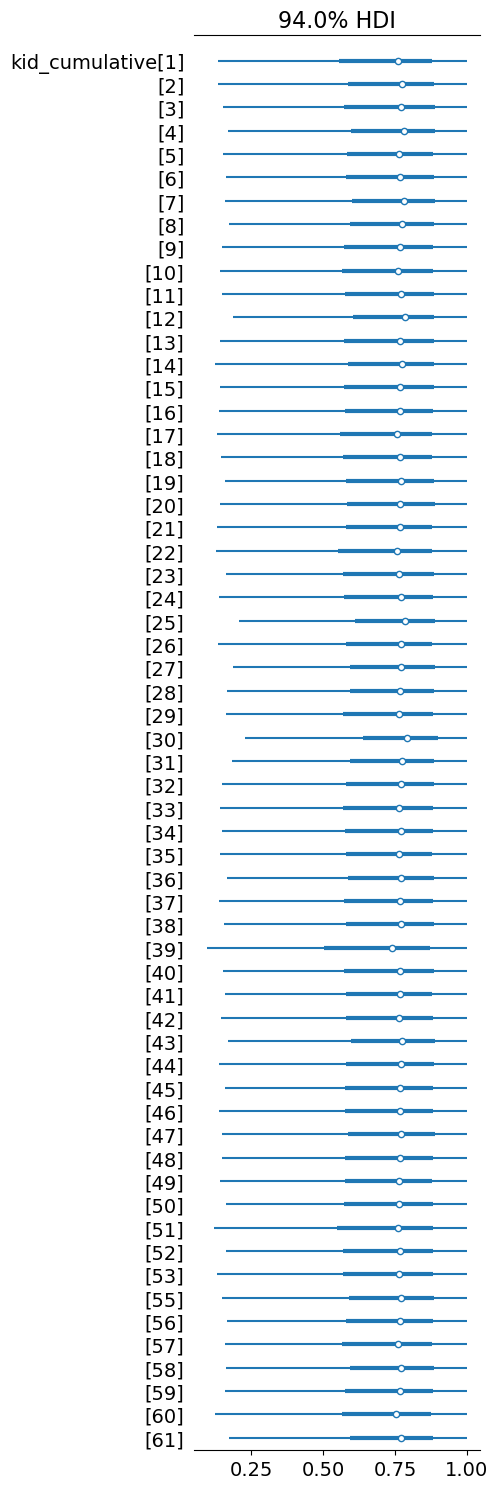

In [14]:
az.plot_forest(
    ex3_trace_3, 
    var_names='kid_cumulative', 
    coords = {"children": 2}, 
    combined=True, 
    #kind='ridgeplot',
    #ridgeplot_overlap=3,
    #colors='white',
    figsize=(5, 15),
)
plt.tight_layout()
plt.show()

In [15]:
az.summary(ex3_trace_3, var_names=['avg_kid_cumulative', 'kid_cumulative'], 
    coords = {"children": 2}, kind='stats')

,mean,sd,hdi_3%,hdi_97%
avg_kid_cumulative,0.782,0.083,0.639,0.944
kid_cumulative[1],0.682,0.260,0.134,1.000
kid_cumulative[2],0.696,0.256,0.133,1.000
kid_cumulative[3],0.692,0.259,0.150,1.000
kid_cumulative[4],0.704,0.249,0.169,1.000
...,...,...,...,...
kid_cumulative[57],0.689,0.252,0.158,1.000
kid_cumulative[58],0.698,0.248,0.162,1.000
kid_cumulative[59],0.692,0.253,0.157,1.000
kid_cumulative[60],0.680,0.261,0.122,1.000


## Monotonic effects that vary by urbanity only

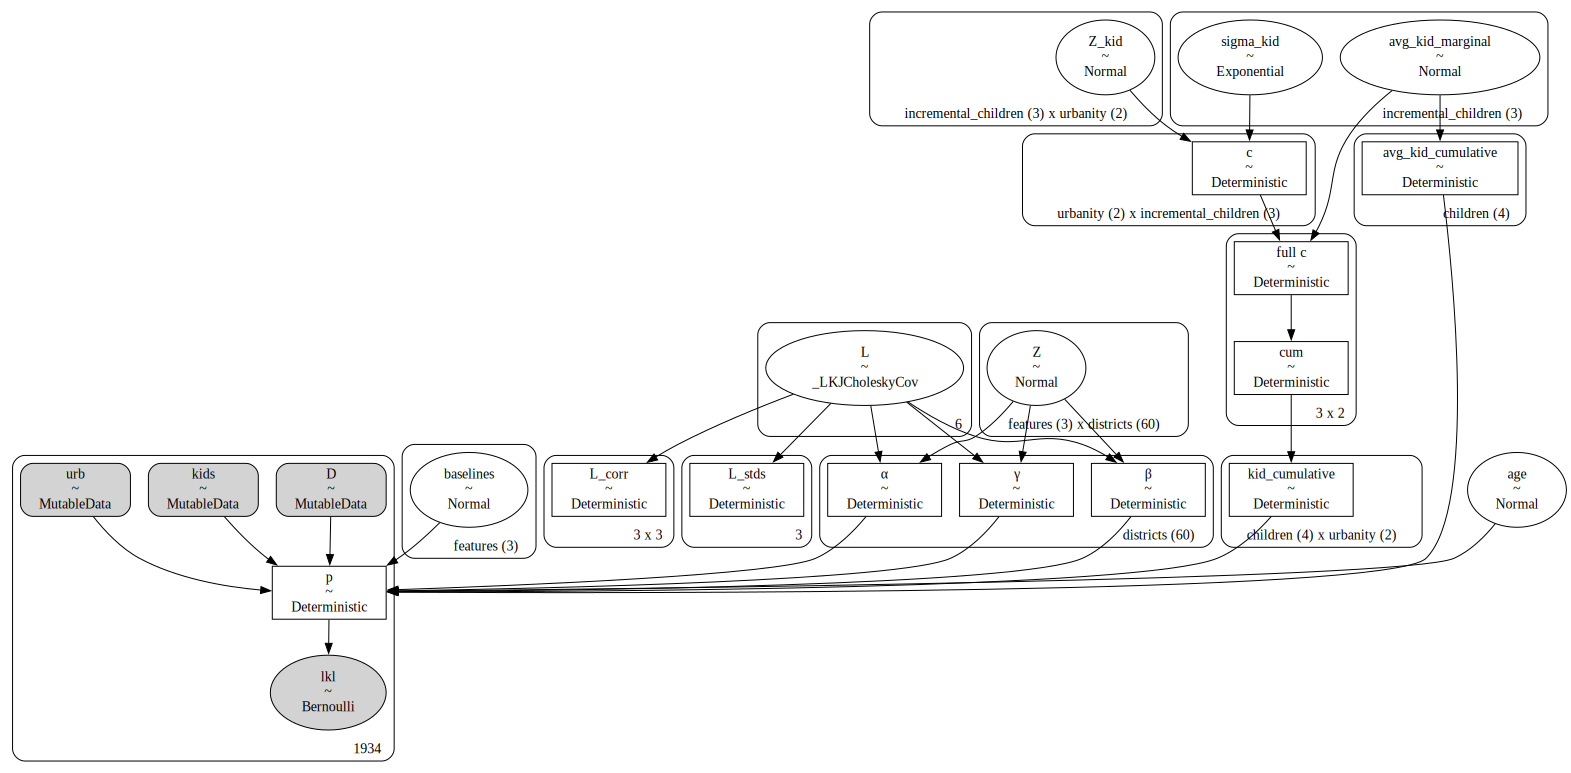

In [3]:
coords = {
    "districts": districts,
    "children": children,
    "incremental_children": children[1:],
    "features": ["district", "urban", "children"],   
    "urbanity": ["rural", "urban"] 
}

with pm.Model(coords = coords) as ex3_model_4:

    #data
    urbanity = pm.MutableData("urb", bangladesh['urban'].values, coords="urbanity")   
    kids = pm.MutableData('kids', children_idx, coords="children")
    D = pm.MutableData('D', d_idx, coords='districts')
    
    #district features    
    σ = pm.Exponential.dist(1.0, shape=len(coords['features']))
    baselines = pm.Normal("baselines", 0, 1, dims="features")    
    chol, corr, stds = pm.LKJCholeskyCov(
        'L', 
        n=len(coords['features']), 
        eta=4, 
        sd_dist=σ, 
        compute_corr=True        
    )

    Z = pm.Normal('Z', mu=0, sigma=1, dims=["features", "districts"])
    vals = pm.math.dot(chol, Z)
        
    α = pm.Deterministic("α", vals[0, :], dims="districts")
    β = pm.Deterministic("β", vals[1, :], dims="districts") 
    γ = pm.Deterministic("γ", vals[2, :], dims="districts")

    #monotonic effect on children using softmax
    # Should also be possible using a pymc Simplex transform, but I could not get it to work
    # np.exp(a) / np.exp(logsumexp(a))
    #        

    #these cutpoints are averages
    avg_raw_cutpoints = pm.Normal(
        "avg_kid_marginal",         
       dims='incremental_children'
    )     

    #save average monotonic effects for reference    
    avg_cutpoints = avg_raw_cutpoints.exp() / pm.math.logsumexp(avg_raw_cutpoints).exp()    
    avg_kid_impact = pm.Deterministic(
        "avg_kid_cumulative", 
        pm.math.concatenate([pm.math.constant(0, ndim=1), avg_cutpoints.cumsum(axis=0)], axis=0),
        dims=['children']
    )

    if True:

        #these are additions for each district; 
        Z_cuts = pm.Normal(
            "Z_kid", 
            mu=0, sigma=1,             
            dims=['incremental_children', 'urbanity']
        ) #3 x D

        #these are variations of the random effects per cut-off point
        sigmas = pm.Exponential(
            "sigma_kid", 
            1,             
            dims='incremental_children'
        ) # 3x1
        
        cutpoint_offsets = pm.Deterministic(
            "c", 
            Z_cuts.T * sigmas.T, # (D x 3) * (1 x 3) = D x 3
            dims=["urbanity", "incremental_children"]
        )

        #compute real monotonic effects with offsets
        raw_cutpoints = pm.Deterministic(
            "full c", 
            (
                avg_raw_cutpoints.flatten() + 
                cutpoint_offsets
            ).T)  #(1 x 3) + (D x 3) = D x 3
        cutpoints = raw_cutpoints.exp() / pm.math.logsumexp(raw_cutpoints, axis=0).exp() 
        cumulative_cutpoints = pm.Deterministic("cum", cutpoints.cumsum(axis=0))
        zeros = pm.math.constant(np.zeros((1, len(coords['urbanity']))))

        kid_impact = pm.Deterministic(
            "kid_cumulative", 
            pm.math.concatenate([zeros, cumulative_cutpoints], axis=0),
            dims=['children', 'urbanity']        
        ) 

    #age
    δ = pm.Normal("age", 0, 1)

    logit = baselines[0] + baselines[1]*urbanity #baseline effects
    logit += baselines[2]*avg_kid_impact[kids] #baseline effects (kids)
    logit += α[D] + β[D]*urbanity #effects of districts    
    logit += γ[D]*kid_impact[kids, urbanity] #effects of districts (kids)
    logit += std_age.values.reshape(-1,)*δ #age effect

    p = pm.Deterministic("p", pm.invlogit(logit))

    pm.Bernoulli("lkl", p = p, observed = bangladesh['use.contraception'].values)

pm.model_to_graphviz(ex3_model_4)

In [4]:
with ex3_model_4:
    ex3_trace_4 = sampling_jax.sample_blackjax_nuts()
    #ex3_trace_3 = pm.sample()

Compiling...


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Compilation time =  0:00:03.358935
Sampling...
Sampling time =  0:00:09.079465
Transforming variables...
Transformation time =  0:00:15.402929


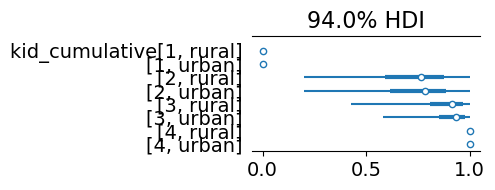

In [5]:
az.plot_forest(
    ex3_trace_4, 
    var_names='kid_cumulative', 
    #coords = {"children": 2}, 
    combined=True,     
    figsize=(5, 2),
)
plt.tight_layout()
plt.show()

### Alternative parameterization

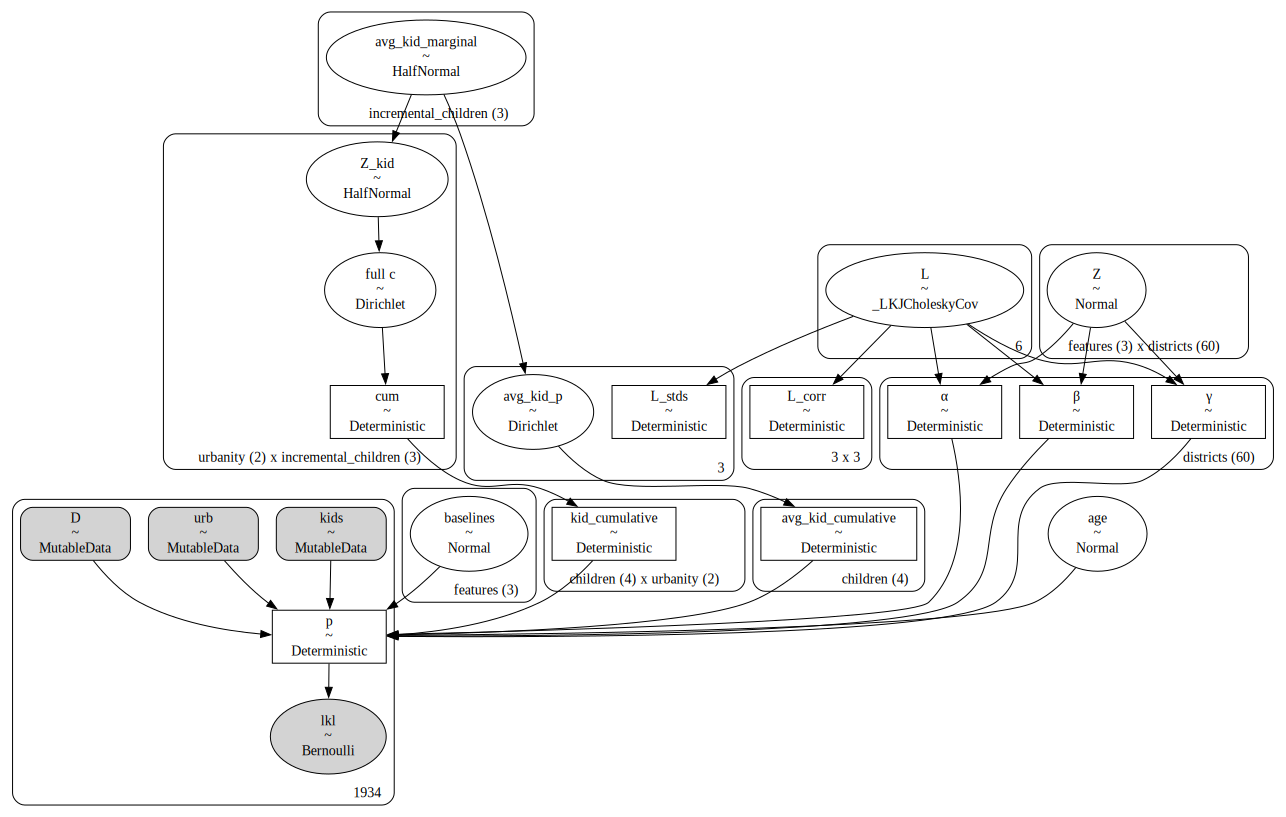

In [11]:
with pm.Model(coords = coords) as ex3_model_5:

    #data
    urbanity = pm.MutableData("urb", bangladesh['urban'].values, coords="urbanity")   
    kids = pm.MutableData('kids', children_idx, coords="children")
    D = pm.MutableData('D', d_idx, coords='districts')
    
    #district features    
    σ = pm.Exponential.dist(1.0, shape=len(coords['features']))
    baselines = pm.Normal("baselines", 0, 1, dims="features")    
    chol, corr, stds = pm.LKJCholeskyCov(
        'L', 
        n=len(coords['features']), 
        eta=4, 
        sd_dist=σ, 
        compute_corr=True        
    )

    Z = pm.Normal('Z', mu=0, sigma=1, dims=["features", "districts"])
    vals = pm.math.dot(chol, Z)
        
    α = pm.Deterministic("α", vals[0, :], dims="districts")
    β = pm.Deterministic("β", vals[1, :], dims="districts") 
    γ = pm.Deterministic("γ", vals[2, :], dims="districts")

    #monotonic effect on children using Dirichlet
    
    #these cutpoints are averages
    avg_raw_cutpoints = pm.HalfNormal(
        "avg_kid_marginal",         
       dims='incremental_children'
    )     

    #save average monotonic effects for reference    
    avg_cutpoints = pm.Dirichlet("avg_kid_p", a=avg_raw_cutpoints)
    avg_kid_impact = pm.Deterministic(
        "avg_kid_cumulative", 
        pm.math.concatenate([pm.math.constant(0, ndim=1), avg_cutpoints.cumsum(axis=0)], axis=0),
        dims=['children']
    )

    if True:
        
        #these are additions for each district; 
        cutpoint_offsets = pm.HalfNormal(
            "Z_kid", 
            sigma=avg_raw_cutpoints.flatten().T, 
            #shape = (2,3)      
            dims=['urbanity', 'incremental_children']
        )
        
        #compute real monotonic effects with offsets
        cutpoints = pm.Dirichlet(
            "full c", 
            a=cutpoint_offsets,
            dims=['urbanity', 'incremental_children']
        )

        cumulative_cutpoints = pm.Deterministic("cum", cutpoints.cumsum(axis=1), dims=['urbanity', 'incremental_children'])
        zeros = pm.math.constant(np.zeros((len(coords['urbanity']), 1)))

        kid_impact = pm.Deterministic(
            "kid_cumulative", 
            pm.math.concatenate([zeros, cumulative_cutpoints], axis=1).T,
            dims=['children', 'urbanity']        
        ) 

    #age
    δ = pm.Normal("age", 0, 1)

    logit = baselines[0] + baselines[1]*urbanity #baseline effects
    logit += baselines[2]*avg_kid_impact[kids] #baseline effects (kids)
    logit += α[D] + β[D]*urbanity #effects of districts    
    logit += γ[D]*kid_impact[kids, urbanity] #effects of districts (kids)
    logit += std_age.values.reshape(-1,)*δ #age effect

    p = pm.Deterministic("p", pm.invlogit(logit))

    pm.Bernoulli("lkl", p = p, observed = bangladesh['use.contraception'].values)

pm.model_to_graphviz(ex3_model_5)

In [12]:
with ex3_model_5:
    #ex3_trace_5 = sampling_jax.sample_blackjax_nuts()
    ex3_trace_5 = pm.sample()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 593 seconds.


In [20]:
az.summary(ex3_trace_5, var_names=['kid_cumulative', 'avg_kid_cumulative'], coords = {"children": [2,3]})

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"kid_cumulative[2, rural]",0.538,0.373,0.000,1.0,0.016,0.011,343.0,183.0,1.01
"kid_cumulative[2, urban]",0.579,0.373,0.000,1.0,0.011,0.008,893.0,796.0,1.00
"kid_cumulative[3, rural]",0.703,0.354,0.013,1.0,0.014,0.010,380.0,691.0,1.01
"kid_cumulative[3, urban]",0.818,0.284,0.164,1.0,0.008,0.006,386.0,2212.0,1.01
avg_kid_cumulative[2],0.856,0.098,0.692,1.0,0.003,0.002,821.0,982.0,1.00
avg_kid_cumulative[3],0.958,0.056,0.850,1.0,0.002,0.001,529.0,395.0,1.01


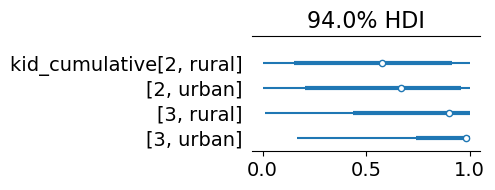

In [15]:
az.plot_forest(
    ex3_trace_5, 
    var_names='kid_cumulative', 
    coords = {"children": [2,3]}, 
    combined=True,     
    figsize=(5, 2),
)
plt.tight_layout()
plt.show()